# Civil Air Patrol and Georegistration

In the previous session, we saw how a series of 2D images taken of a 3D scene can be used to recover the 3D information, by exploiting geometric constraints of the cameras. Now the question is, how do we take this technique and apply it in a disaster response scenario?

We are going to look at a specific case study, using images from the Low Altitude Disaster Imagery (LADI) dataset, taken by the Civil Air Patrol (CAP). As we work with this dataset, keep in mind the two major questions from the previous lecture:

- _What_ is in an image (e.g. debris, buildings, etc.)?
- _Where_ are these things located _in 3D space_ ?

## Civil Air Patrol
Civil Air Patrol (CAP) is the civilian auxiliary of the United States Air Force (USAF). The origins of CAP date back to the pre-World War II era. As the Axis powers became a growing threat to the world, civilian aviators in the United States feared that the government would shut down general aviation as a precautionary measure. These aviators thus had to prove to the federal government that civilian aviation was not only not a danger, but actually a benefit to the war effort. 

As a result of these efforts, two separate programs were created. One was a Civilian Pilot Training Program, intended to increase the available people that could operate an aircraft should the need to deploy additional troops arise. The second actually called for the organization of civilian aviators and opened the door to the creation of CAP. 

Once the United States entered WWII proper, CAP began to embark a plethora of activities, some of which are still practiced today. They continued to do cadet education programs. They also began patrolling the coasts and borders. Finally, they started in 1942 conducting search and rescue (SAR) missions. These missions were a resounding success, and one of the main components of CAP today.

CAP has five congressionally mandated missions:

(1) To provide an organization to—
(A) encourage and aid citizens of the United States in contributing their efforts, services, and resources in developing aviation and in maintaining air supremacy; and
(B) encourage and develop by example the voluntary contribution of private citizens to the public welfare.

(2) To provide aviation education and training especially to its senior and cadet members.

(3) To encourage and foster civil aviation in local communities.

(4) To provide an organization of private citizens with adequate facilities to assist in meeting local and national emergencies.

(5) To assist the Department of the Air Force in fulfilling its noncombat programs and missions.

source: https://www.law.cornell.edu/uscode/text/36/40302

CAP's main series of missions revolve around emergency response. CAP is involved in roughly 85% of all SAR missions in the United States and its territories. After natural disasters, CAP is responsible for assessing damage in affected communities, delivering supplies, providing transportation, in addition to its usual SAR missions. 

https://kvia.com/health/2020/06/18/el-paso-civil-air-patrol-flying-virus-tests-to-labs-in-money-saving-effort-for-texas/

https://www.southernminn.com/article_2c5739a5-826f-53bb-a658-922fb1aa1627.html

Part of their emergency programming is taking aerial imagery of affected areas. This imagery is the highest resolution, most timely imagery that we have available of a post-disaster situation. Even the highest resolution satellite imagery is often either limited in their geographical coverage, not very timely or occluded by clouds. These are images taken of Puerto Rico after Hurricane Maria in 2017.

<img src="notebook_images/A0008AP-_932ec345-75a9-4005-9879-da06ba0af37e.jpg" width="500"  />

<img src="notebook_images/A0016-52_e71b5e09-ec3c-4ea6-8ac8-b9d1e4b714cb.jpg" width="500"  />

<img src="notebook_images/A0016-54_f5273b60-dec4-4617-8f01-d67f16001dcb.jpg" width="500"  />

CAP has taken hundreds of thousands of images of disaster-affected areas in the past decades. And yet, even though it is some of the best imagery we have access to, it is rarely if ever used in practice. _Why?_

## The LADI dataset
Part of the effort in making CAP imagery more useful is trying to make more sense of the content of the images. To that end, researchers at MIT Lincoln Laboratory released the Low Altitude Disaster Imagery (LADI) dataset. This dataset contains hundreds of thousands of CAP images that have crowdsourced labels corresponding to infrastructure, environment and damage categories. This begins to answer the first of the two questions we set out initially. We'll start working on these labels tomorrow. For now, we will solely focus on the images themselves.

<img src="notebook_images/labels.png" width="500"  />

What are some of the limitations of this dataset?

### Exercise

Imagine you have acquired $200,000 to implement some improvement to the way CAP takes aerial imagery. Hurricane season starts in five months, so whatever improvements need to be implemented by then. Separate into your breakout rooms and answer the following questions:
- What specific hurdles to using CAP images do you want to address? Identify at least two.
- Design a proposal to address the challenges you identified above, taking into account the budget and time constraints. Improvements can be of any sort (technical, political, social, etc).
- What are the advantages and disadvantages of implementing your proposal?
- Identify at least three different stakeholder groups in this situation. What are their specific needs? How does your proposal address these needs? How does your proposal fall short?
- Draw out a budget breakdown and a timeline, as well as a breakdown of which stakeholders you are prioritizing and why. Prepare to present these at 1:30pm.

## 3D Reconstruction in a Real World Reference Frame

If we want to answer the second of our two guiding questions, we must be able to make a translation between where something is in the image and its location in real world coordinates. Let's stake stock of what tools we have thus far. We spent a good amount of time discussing structure from motion as a way to reconstruct a 3D scene from 2D images. Recall the limitations of this approach:
- There need to be more than one image in a sequence.
- Sequential images need to have enough overlap that there are common features.
- At least one pair of sequential images must have sufficient translation such that the problem is not ill-posed.
- The reconstruction is given in an arbitrary reference frame up to scale. 

What does that last point mean? The arbitrary reference part refers to the fact that the origin and the axes are aligned with the first camera. The up to scale part means that all distances are preserved up to a factor $\lambda$. Therefore the scene retains the general shape, but the size of the scene is not conserved. Without additional information, it is impossible to know how the reconstructed scene relates to any other reference frame, and translating the reconstruction to real world coordinates is impossible.

However, recall that we do typically have at least a coarse estimate of the camera's GPS coordinates, therefore we have estimates of the distances between sequential cameras. Consider a reconstruction of just two images. Then a good estimate of $\lambda$ is:

$\lambda = \frac{D_{GPS}}{D_{reconstruction}}$

This is slightly more complicated for more than two images. Typically, a solver will initialize the camera positions at their GPS coordinates and use bundle adjustment to correct the errors in the GPS measurements, although certainly there's more than one way to do this.

Let's give this a shot and see what happens! As it so happens, OpenSfM is already equipped to handle GPS coordinates. 

In [1]:
import sys
import open3d as o3d
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import os

In [2]:
# Take initial guess of intrinsic parameters through metadata
!opensfm extract_metadata CAP_sample_1

# Detect features points 
!opensfm detect_features CAP_sample_1

# Match feature points across images
!opensfm match_features CAP_sample_1

# This creates "tracks" for the features. That is to say, if a feature in image 1 is matched with one in image 2,
# and in turn that one is matched with one in image 3, then it links the matches between 1 and 3. 
!opensfm create_tracks CAP_sample_1

# Calculates the essential matrix, the camera pose and the reconstructed feature points
!opensfm reconstruct CAP_sample_1


2020-07-17 15:50:24,089 INFO: Loading existing EXIF for image_url_pr_10_13_sample_12.jpg
2020-07-17 15:50:24,090 INFO: Loading existing EXIF for image_url_pr_10_13_sample_11.jpg
2020-07-17 15:50:24,090 INFO: Loading existing EXIF for image_url_pr_10_13_sample_08.jpg
2020-07-17 15:50:24,091 INFO: Loading existing EXIF for image_url_pr_10_13_sample_07.jpg
2020-07-17 15:50:24,092 INFO: Loading existing EXIF for image_url_pr_10_13_sample_13.jpg
2020-07-17 15:50:26,069 INFO: Skip recomputing ROOT_HAHOG features for image image_url_pr_10_13_sample_12.jpg
2020-07-17 15:50:26,070 INFO: Skip recomputing ROOT_HAHOG features for image image_url_pr_10_13_sample_11.jpg
2020-07-17 15:50:26,070 INFO: Skip recomputing ROOT_HAHOG features for image image_url_pr_10_13_sample_08.jpg
2020-07-17 15:50:26,070 INFO: Skip recomputing ROOT_HAHOG features for image image_url_pr_10_13_sample_07.jpg
2020-07-17 15:50:26,070 INFO: Skip recomputing ROOT_HAHOG features for image image_url_pr_10_13_sample_13.jpg
2020-

In [3]:
# adding the --all command to include all partial reconstructions
!opensfm export_ply --all CAP_sample_1


In [4]:
import open3d as o3d
from open3d import JVisualizer

# it turns out that we have two partial reconstructions from the reconstruct command
# open3d actually has a very convenient way of combining point clouds, just by using the + operator
pcd = o3d.io.read_point_cloud("CAP_sample_1/reconstruction_files/reconstruction_0.ply")
pcd += o3d.io.read_point_cloud("CAP_sample_1/reconstruction_files/reconstruction_1.ply")
visualizer = JVisualizer()
visualizer.add_geometry(pcd)
visualizer.show()

JVisualizer with 1 geometries

So what are we seeing? We see two collections of points, both mostly coplanar internally (which we expect, given that this is a mostly planar scene), but the two sets are not aligned with each other! Let's look a bit more closely...

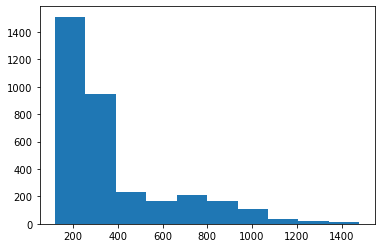

In [5]:
# here, we're just going to plot the z (altitude) values of the reconstructed points
point_coord = np.asarray(pcd.points)
plt.hist(point_coord[:, 2].ravel())
plt.show()

So not only are the points misaligned, but we're getting wild altitude values! **What's going on?**

### Exercise
Let's make a critical assumption: all of the image coordinates (the GPS coordinates of the camera as it takes an image) all lie on a plane (in the mathematical sense). Answer the following questions:
- How many points are needed to specify a (mathematical) plane?
- In addition to the number of points, what other requirement do those points need?
- Look at the visualization above. Do the camera points fulfill that requirement?
- One way to resolve the ambiguity is to determine what direction is "up" (i.e. pointing away from the center of the Earth). Propose a solution to determine the up-vector. You can either assume the same setup that we currently have or propose new sensors/other setups.

<details>
    <summary>CLICK HERE TO SEE THE PROPOSED SOLUTION</summary>
    We're going to make a fair (but limited) assumption that the ground is mostly flat. It turns out we can fit a plane through the reconstructed ground points and find a direction perpendicular to the plane (called the plane normal). If the ground is flat, then the normal should be close enough to the up direction. Note that this assumption does not hold for an area with a lot of inclination. In practice, we would most likely augment this with a Digital Elevation Model (DEM)

</details>

<img src="notebook_images/plane_normal.png" width="500"  />

To implement the proposed solution, we can go to the CAP_sample_1/config.yaml file and modify "align_orientation_prior" from "horizontal" to "plane_based". Afterwards, we run the previous commands as usual.

In [6]:
# This creates "tracks" for the features. That is to say, if a feature in image 1 is matched with one in image 2,
# and in turn that one is matched with one in image 3, then it links the matches between 1 and 3. 
!opensfm create_tracks CAP_sample_1

# Calculates the essential matrix, the camera pose and the reconstructed feature points
!opensfm reconstruct CAP_sample_1

# adding the --all command to include all partial reconstructions
!opensfm export_ply --all CAP_sample_1

2020-07-17 15:50:42,846 INFO: reading features
2020-07-17 15:50:42,900 DEBUG: Merging features onto tracks
2020-07-17 15:50:42,943 DEBUG: Good tracks: 3429
2020-07-17 15:50:45,033 INFO: Starting incremental reconstruction
2020-07-17 15:50:45,081 INFO: Starting reconstruction with image_url_pr_10_13_sample_11.jpg and image_url_pr_10_13_sample_12.jpg
2020-07-17 15:50:45,119 INFO: Two-view reconstruction inliers: 1748 / 1748
2020-07-17 15:50:45,316 INFO: Triangulated: 1551
2020-07-17 15:50:45,343 DEBUG: Ceres Solver Report: Iterations: 3, Initial cost: 3.447386e+02, Final cost: 3.387344e+02, Termination: CONVERGENCE
2020-07-17 15:50:45,494 DEBUG: Ceres Solver Report: Iterations: 3, Initial cost: 3.402295e+02, Final cost: 3.387048e+02, Termination: CONVERGENCE
Align plane:  [ 0.03595051 -0.99933397  0.00625842  0.        ]
2020-07-17 15:50:45,725 DEBUG: Ceres Solver Report: Iterations: 16, Initial cost: 2.366617e+01, Final cost: 1.747716e+01, Termination: CONVERGENCE
2020-07-17 15:50:45,73

## Georegistration

The process of assigning GPS coordinates to individual pixels is called _georegistration_ or _georeferencing_. This requires us to perform a final transformation from pixel coordinates *per each image* to the 3D reconstructed coordinates. Before doing so, it is worthwhile talking a bit about what exactly our 3D coordinate system is. 

You might recall that not all coordinate referece systems lend themselves well to geometric transformations. Specifically, we want our 3D coordinate system to be Cartesian (i.e. three orthogonal, right-handed axes). OpenSfM performs its reconstructions in what is known as a *local tangent plane coordinate system* called *local east, north, up (ENU) coordinates*. The way this works is, you select an origin somewhere in the world (in our case, it is saved in the reference_lla.json file), and you align your axes such that the x-axis is parallel to latitudes and increasing Eastward, the y-axis is parallel to meridians and increasing Northward, and the z-axis is pointing away from the center of the Earth. The image below shows how this works:

<img src="notebook_images/enu.png" width="500"  />

In order to convert from ENU coordinates to geodetic coordinates (i.e. latitude, longitude, altitude), you need to know the origin. 

In [7]:
# Origin of our reconstruction, as given by the reference_lla.json (made from the reconstruction)
with open("CAP_sample_1/reference_lla.json", "r") as f:
    reference_lla = json.load(f)
    latitude=reference_lla["latitude"]
    longitude=reference_lla["longitude"]
    altitude=reference_lla["altitude"]

# This is the json file that contains the reconstructed feature points
with open("CAP_sample_1/reconstruction.json", "r") as f:
    reconstructions = json.load(f)

There is a bit of work we need to go through to finalize the georegistration. First, we need to match the reconstructed features with the features on an image the tracks.csv file and the reconstruction.json can help us do that. The columns of tracks are as follows: image name, track ID (ID of the reconstructed point), feature ID (ID of the feature within the image), the *normalized* image coordinates x and y, the normalization factor s, and the color of the feature RGB.

In [8]:
from opensfm.features import denormalized_image_coordinates

# reading the csv
tracks = pd.read_csv("CAP_sample_1/tracks.csv", sep="\t", skiprows=1, names=["image_name", "track_id", "feature_id", "x", "y", "s", "R", "G", "B"])

# we need to denormalize the coordinates to turn them into regular pixel coordinates
normalized_coor = tracks[["x", "y", "s"]]
denormalized_coor = denormalized_image_coordinates(normalized_coor.values, 4496, 3000)

# create a new column with the denormalized coordinates
tracks["denorm_x"] = denormalized_coor[:, 0]
tracks["denorm_y"] = denormalized_coor[:, 1]

We're going to store the georegistration by creating a new .tif file for every CAP image. As you can recall, .tif files save not just the pixel data but also the projection that allows it to be displayed on top of other map data. There are two parts to doing this:
- First, we need to create an _orthorectified_ image. Simply put, this is one that is transformed such that it looks as though you are looking at it from the top down. 
- Second, we need to add *ground control points* (GCPs) to the orthorectified image. GCPs are correspondences between world coordinates and pixel coordinates.

Once we add the GCPs, any mapping software can plot the image such that the GCPs are aligned with their underlying coordinates. 

In [9]:
import shutil
import gdal, osr
try:
    from pymap3d import enu2geodetic
except:
    !pip install pymap3d
    from pymap3d import enu2geodetic

import random
from skimage import transform

if not os.path.isdir("CAP_sample_1/geotiff/"):
    os.mkdir("CAP_sample_1/geotiff/")
if not os.path.isdir("CAP_sample_1/ortho/"):
    os.mkdir("CAP_sample_1/ortho/")

for reconst in reconstructions:
    for shot in reconst["shots"]:
        # some housekeeping
        shot_name = shot.split(".")[0]
        img = cv2.imread("CAP_sample_1/images/"+shot)
        shape = img.shape
        
        # here we get the features from the image and their corresponding reconstructed features
        reconst_ids = list(map(int, reconst["points"].keys()))
        tracks_shot = tracks[(tracks["image_name"] == shot) & (tracks["track_id"].isin(reconst_ids))]
        denorm_shot = np.round(tracks_shot[["denorm_x", "denorm_y"]].values)
        reconst_shot = np.array([reconst["points"][str(point)]["coordinates"] for point in tracks_shot["track_id"]])
        
        # we're going to create an image that is distorted to fit within the world coordinates
        # pix_shot is just the reconstructed feature coordinates offset by some amount so that
        # all coordinates are positive.
        offset = np.min(reconst_shot[:, :2])
        pix_shot = reconst_shot[:, :2]-np.multiply(offset, offset<0)
        
        # transformation for the new orthorectified image
        H, inliers = cv2.findHomography(denorm_shot, pix_shot)
        
        # filtering out points that didn't fit the transformation
        reconst_shot = reconst_shot[inliers.ravel()==1, :]
        denorm_shot = np.round(denorm_shot[inliers.ravel()==1, :])
        pix_shot = np.round(pix_shot[inliers.ravel()==1, :])
        
        # creating the ortho image
        shape = tuple(np.max(pix_shot, axis=0).astype(int))
        ortho_img = cv2.warpPerspective(img, H, shape)
        cv2.imwrite("CAP_sample_1/ortho/" + shot + "_ortho.jpg", ortho_img)
        
        # here we convert all of the reconstructed points into lat/lon coordinates
        geo_shot = np.array([enu2geodetic(reconst_shot[i, 0],reconst_shot[i, 1],reconst_shot[i, 2],latitude,longitude,altitude) for i in range(reconst_shot.shape[0])])        
        
        idx = random.sample(range(len(geo_shot)), 10)
        pix_shot_sample = pix_shot[idx, :]
        geo_shot_sample = geo_shot[idx, :]
                
        # creating the Ground Control Points
        orig_fn = "CAP_sample_1/ortho/" + shot + "_ortho.jpg"
        fn = "CAP_sample_1/geotiff/" + shot_name + "_GCP.tif"
        
        orig_ds = gdal.Open(orig_fn)
        gdal.GetDriverByName('GTiff').CreateCopy(fn, orig_ds)
        ds = gdal.Open(fn, gdal.GA_Update)
        sr = osr.SpatialReference()
        sr.SetWellKnownGeogCS('WGS84')
        
        gcps = [gdal.GCP(geo_shot_sample[i, 1], geo_shot_sample[i, 0], 0, int(pix_shot_sample[i, 0]), int(pix_shot_sample[i, 1])) for i in range(geo_shot_sample.shape[0])]
        
        ds.SetGCPs(gcps, sr.ExportToWkt())
        
        ds = None
        


Processing /home/jovyan/.cache/pip/wheels/0c/24/19/30c440838faa979cd09d8ac37ae866669b980bfdaed4d0fb91/pymap3d-2.4.1-py3-none-any.whl


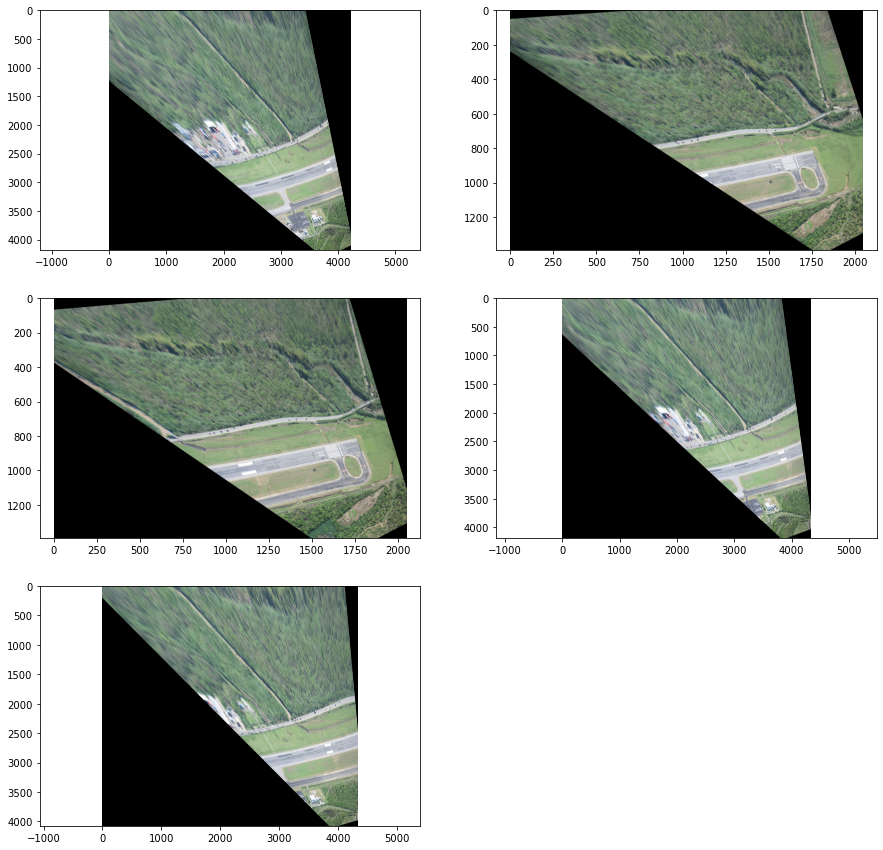

In [42]:
import rasterio
import rasterio.plot

fig = plt.figure(figsize=(15, 15))
files = [os.path.join('CAP_sample_1/geotiff/', f) for f in os.listdir('CAP_sample_1/geotiff/') if f.endswith("tif")]

for i, file in enumerate(files):
    with rasterio.open(file, "r") as dataset:
#         dataset_mask = dataset.read_masks(1)
#         dataset_read = dataset.read(1)
#         rasterio.plot.show(np.ma.masked_where(dataset_mask==0, dataset_read), ax=ax)
        ax = fig.add_subplot(3, 2, i+1)
        rasterio.plot.show(dataset, ax=ax)
        ax.axis("equal")

## Exercise
In the lesson folder, there is a spreadsheet with CAP images and their coordinates taken on October 13th, 2017. 
- Use geopandas to visualize the coordinates of all the images, and overlay it with some basemap
- Select an area of those images that looks interesting to you. Use SfM to reconstruct at least 10 images
- For those 10 images, select at least one and go through the georegistration process. Does the georegistration process yield good alignment with the ground truth? If not, why do you think that is?

I **strongly** encourage you to tackle this as a team! Feel free to divide the tasks up as you see fit. 